# <font color="orange">Load modules</font> 

In [1]:
import cv2
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import sklearn.model_selection
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from sklearn.cluster import KMeans
from tensorflow.keras import datasets, layers, models
import sys
sys.path.append("/Users/macbookpro/UCL - MSc Integrated Machine Learning Systems/Y1/Applied Machine Learning I/Final Assignment/AMLS_20-21_SN17024244")
from _CFG_Task_B import *
from _CLASS_ImageManager import *

In the following lines we load the labels .csv file.

In [2]:
y = load_images_label_csv("face_shape")

The following code is to remove the test_set in case this has been moved from cartoon_set_test/img to cartoon_set/img.

In [3]:
if count_n_images(sub_folder, extension) > 10000:
    move_images_fromfolder(sub_folder, sub_test_folder, extension)

# <font color="orange">Load and process images</font> 

We leverage on the **ImageManager** class object to load the whole set of images as well as crop them based on the body part we are interested in. The processing is based on a Haar Cascade Classifier. This is an effective object detection approach which was proposed by Paul Viola and Michael Jones back in 2001. This is basically a machine learning based approach where a cascade function is trained from a lot of images both positive and negative. Based on the training it is then used to detect the objects in the other images.
So how this works is they are huge individual .xml files with a lot of feature sets and each .xml corresponds to a very specific type of use case. Further to this process, the **ImageManager** class operates a Canny Edge detection step in addition to cropping. By specifying the hysteresis parameters, we can optimize the final choice of the edge.

In [4]:
imgmgr = ImageManager()
imgmgr.load_images_from_folder(sub_folder, extension, verbose = True)
imgmgr.bodypart = "face"
imges = imgmgr.crop_part((100,100), squaring=False, x_offsets=(0,0), y_offsets = (0,0))
imges = imgmgr.canny_images()

Starting to load images from /Users/macbookpro/UCL - MSc Integrated Machine Learning Systems/Y1/Applied Machine Learning I/Final Assignment/AMLS_20-21_SN17024244/Datasets/dataset_AMLS_20-21/cartoon_set/img/ with extension .png
835/10000 images loaded
1538/10000 images loaded
2256/10000 images loaded
3024/10000 images loaded
3743/10000 images loaded
4719/10000 images loaded
5698/10000 images loaded
6590/10000 images loaded
7263/10000 images loaded
7897/10000 images loaded
8535/10000 images loaded
9261/10000 images loaded
9924/10000 images loaded
10000/10000 images loaded


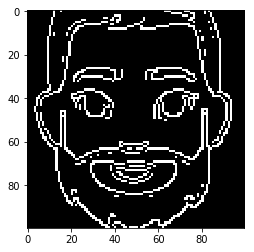

In [5]:
rgb = cv2.cvtColor(imges[5], cv2.COLOR_BGR2RGB)
plt.imshow(rgb)

# <font color="orange">Solving exercise using various machine learning approches</font> 

Once our images have been processed, we can split our dataset into train and test sets.

In [6]:
X = imgmgr.images
X = X.reshape(X.shape[0], np.prod(X.shape[1:]))
X_train, X_test, y_train, y_test = train_test_split(X, y)

### 1. Random Forest

Now we build our model using a Random Forest classifier. It is noticeable that by reducing the input vector size (from (256,256)), ie resizing the shape of processed images, the Random Forest classifier returns a higher accuracy on the training set. It is also noticeable that overfitting is present as there is almost 100% precision on the training set. Also the "max_depth" argument contributes significantly to our model performance. More complex trees return higher accuracy.

In order to reduce overfitting, the "max_leaf_nodes" argument has been set to a specific number. This will prune the overall tree structure.

In [7]:
clf = RandomForestClassifier(n_estimators = 80, 
                             max_depth = 100, 
                             criterion = "entropy",
                             max_leaf_nodes = 130,
                             max_features="auto")
clf.fit(X_train, y_train)
y_pred_test = clf.predict(X_test)
y_pred_train = clf.predict(X_train)
print("TRAIN METRICS")
print(sklearn.metrics.classification_report(y_train, y_pred_train))
print("TEST METRICS")
print(sklearn.metrics.classification_report(y_test, y_pred_test))

TRAIN METRICS
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      1500
           1       0.97      0.89      0.93      1504
           2       0.87      0.94      0.91      1498
           3       0.96      0.88      0.92      1507
           4       0.82      0.95      0.88      1491

    accuracy                           0.91      7500
   macro avg       0.92      0.91      0.91      7500
weighted avg       0.92      0.91      0.91      7500

TEST METRICS
              precision    recall  f1-score   support

           0       0.88      0.77      0.82       500
           1       0.84      0.72      0.77       496
           2       0.67      0.83      0.74       502
           3       0.86      0.67      0.75       493
           4       0.69      0.86      0.76       509

    accuracy                           0.77      2500
   macro avg       0.79      0.77      0.77      2500
weighted avg       0.79      0.77      0.77      2

No handles with labels found to put in legend.


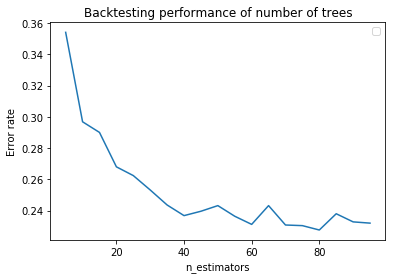

In [8]:
n_estimators=np.arange(5, 100, 5)

# Dictionary containing (<n_estimators>, <error rate>) pairs.
d = {}

for x in n_estimators:
    clf.set_params(n_estimators=x)
    clf.fit(X_train, y_train)
    error = 1 - clf.score(X_test, y_test)
    d[x] = error

plt.plot(d.keys(), d.values())
plt.xlabel("n_estimators")
plt.ylabel("Error rate")
plt.legend(loc="upper right")
plt.title('Backtesting performance of number of trees')
plt.show()

We present the confusion matrix once data has been trained using Random Forest.

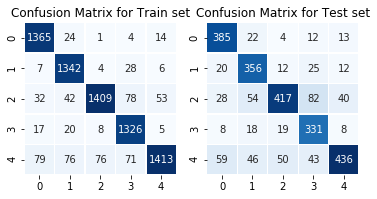

In [9]:
train_test_confusion_matrix(y_train, y_pred_train, y_test, y_pred_test)

In [10]:
param_grid = {"n_estimators":   [40, 60, 80],
              "max_leaf_nodes": [90, 130],
              "max_features":   ["auto", "sqrt", "log2"]}

In [11]:
grid_clf = sklearn.model_selection.GridSearchCV(clf, param_grid, cv=5)
grid_clf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(criterion='entropy',
                                              max_depth=100, max_leaf_nodes=130,
                                              n_estimators=95),
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'max_leaf_nodes': [90, 130],
                         'n_estimators': [40, 60, 80]})

In [12]:
results_table = pd.DataFrame.from_dict(grid_clf.cv_results_).set_index("rank_test_score")
results_table

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_max_leaf_nodes,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,,,,
11,2.390736,0.040671,0.039351,0.004959,auto,90,40,"{'max_features': 'auto', 'max_leaf_nodes': 90,...",0.700667,0.734667,0.743333,0.710667,0.718667,0.721600,0.015553
10,3.452643,0.022540,0.041518,0.002256,auto,90,60,"{'max_features': 'auto', 'max_leaf_nodes': 90,...",0.710667,0.741333,0.741333,0.714000,0.726000,0.726667,0.013016
7,4.546474,0.033425,0.051229,0.002100,auto,90,80,"{'max_features': 'auto', 'max_leaf_nodes': 90,...",0.720000,0.744000,0.753333,0.732667,0.747333,0.739467,0.011831
5,2.529569,0.038080,0.038487,0.001474,auto,130,40,"{'max_features': 'auto', 'max_leaf_nodes': 130...",0.723333,0.760000,0.760000,0.731333,0.732000,0.741333,0.015543
3,3.716958,0.048934,0.047374,0.002316,auto,130,60,"{'max_features': 'auto', 'max_leaf_nodes': 130...",0.740000,0.764667,0.772667,0.733333,0.756000,0.753333,0.014745
2,4.883446,0.051179,0.052681,0.002457,auto,130,80,"{'max_features': 'auto', 'max_leaf_nodes': 130...",0.732667,0.758667,0.776667,0.754667,0.754667,0.755467,0.014006
12,2.315201,0.020439,0.035971,0.001721,sqrt,90,40,"{'max_features': 'sqrt', 'max_leaf_nodes': 90,...",0.700000,0.732000,0.732667,0.716000,0.718667,0.719867,0.012018
9,3.379859,0.043934,0.042761,0.001439,sqrt,90,60,"{'max_features': 'sqrt', 'max_leaf_nodes': 90,...",0.716667,0.751333,0.750000,0.716000,0.738667,0.734533,0.015500
6,4.509987,0.009546,0.051986,0.002499,sqrt,90,80,"{'max_features': 'sqrt', 'max_leaf_nodes': 90,...",0.712000,0.748000,0.754667,0.731333,0.752000,0.739600,0.016009


### 2. Convolutional Neural Network

In [13]:
X = X.reshape(10000,100,100,1)
X_train, X_test, Y_train, Y_test = train_test_split(X, y)

uint8 0 255 (10000, 100, 100, 1)
int64 0 4 (10000,)


In [14]:
nb_filters = 16 # for convolutional layer
nb_pool = 8 # for MaxPool layer
nb_conv = 3 # for convolutional layer
nb_classes = 5 # for dense layer, multiclassification problem
activation = layers.LeakyReLU(alpha=0.3)

model = models.Sequential()

model.add(layers.Conv2D(nb_filters, (nb_conv, nb_conv), activation=activation, input_shape=X.shape[1:]))
model.add(layers.Conv2D(nb_filters, (nb_conv, nb_conv), activation=activation))
model.add(layers.MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation=activation))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, Y_train, epochs=10, 
                    validation_data=(X_test, Y_test))

Epoch 1/10
235/235 [==============================] - 36s 153ms/step - loss: 12.2426 - accuracy: 0.2613 - val_loss: 1.4802 - val_accuracy: 0.3876
Epoch 2/10
235/235 [==============================] - 38s 163ms/step - loss: 1.6293 - accuracy: 0.3956 - val_loss: 1.1530 - val_accuracy: 0.5732
Epoch 3/10
235/235 [==============================] - 38s 160ms/step - loss: 1.3015 - accuracy: 0.5089 - val_loss: 0.8884 - val_accuracy: 0.6848
Epoch 4/10
235/235 [==============================] - 38s 162ms/step - loss: 1.0901 - accuracy: 0.5937 - val_loss: 0.7869 - val_accuracy: 0.7400
Epoch 5/10
235/235 [==============================] - 38s 162ms/step - loss: 0.9249 - accuracy: 0.6603 - val_loss: 0.6556 - val_accuracy: 0.7788
Epoch 6/10
235/235 [==============================] - 38s 161ms/step - loss: 0.8288 - accuracy: 0.6972 - val_loss: 0.5787 - val_accuracy: 0.8064
Epoch 7/10
235/235 [==============================] - 38s 162ms/step - loss: 0.7477 - accuracy: 0.7359 - val_loss: 0.5169 - val_a

In [15]:
Y_pred_test = np.argmax(model.predict(X_test), axis=1)
Y_pred_train = np.argmax(model.predict(X_train), axis=1)
print("TRAIN METRICS")
print(sklearn.metrics.classification_report(Y_train, Y_pred_train))
print("TEST METRICS")
print(sklearn.metrics.classification_report(Y_test, Y_pred_test))

TRAIN METRICS
              precision    recall  f1-score   support

           0       0.98      0.92      0.95      1482
           1       0.93      0.87      0.90      1513
           2       0.87      0.95      0.91      1510
           3       0.87      0.89      0.88      1478
           4       0.95      0.96      0.96      1517

    accuracy                           0.92      7500
   macro avg       0.92      0.92      0.92      7500
weighted avg       0.92      0.92      0.92      7500

TEST METRICS
              precision    recall  f1-score   support

           0       0.94      0.81      0.87       518
           1       0.87      0.79      0.83       487
           2       0.79      0.90      0.84       490
           3       0.77      0.83      0.80       522
           4       0.90      0.92      0.91       483

    accuracy                           0.85      2500
   macro avg       0.85      0.85      0.85      2500
weighted avg       0.85      0.85      0.85      2

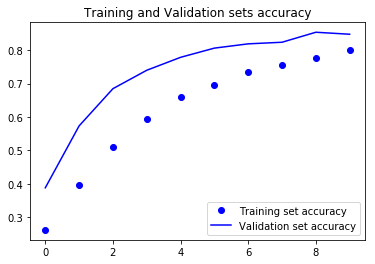

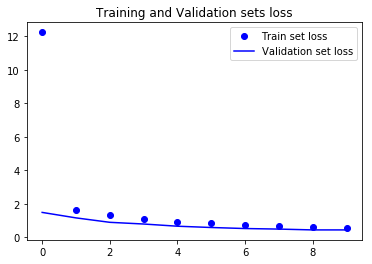

In [16]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training set accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation set accuracy')
plt.xlabel("Number of Epochs")
plt.ylabel("Score")
plt.title('Training and Validation sets accuracy')
plt.show()

In [1]:
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Train set loss')
plt.plot(epochs, val_loss, 'b', label='Validation set loss')
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title('Training and Validation sets loss')
plt.legend()
plt.show()

NameError: name 'plt' is not defined